# Example 1 - Runup

This example solves the shallow-water wave equation for a flat bed that is sloping at a fixed angle in one direction. It demonstrates the basic ideas involved in setting up a modeling scenario.

In [1]:
################################################################################################
# Import ANUGA
################################################################################################

# These lines get around a bug in NetCDF library that stops
# printing to the Notebook
# Save targets of output before the library change them
import sys
default_stdout = sys.stdout
default_stderr = sys.stderr

"""Simple water flow example using ANUGA

Water driven up a linear slope and time varying boundary,
similar to a beach environment
"""

#------------------------------------------------------------------------------
# Import necessary modules
#------------------------------------------------------------------------------
import anuga
from math import sin, pi, exp

# these lines get around a bug in NetCDF library that stops
# printing to the Notebook
# Re-sets targets of output to what they were before the library changed them
reload(sys)
sys.stdout = default_stdout
sys.stderr = default_stderr

In [2]:
################################################################################################
# Create the computational domain
# Generates a 10 meter x 5 meter rectangular triangular mesh with 1 meter spacing
################################################################################################

domain = anuga.rectangular_cross_domain(10,          # number of cells in x direction
                                        5,           # number of cells in y direction
                                        len1 = 10.0, # length in x direction (meters)
                                        len2 = 5.0)  # length in y direction (meters)








################################################################################################
# Set initial conditions
################################################################################################

def topography(x, y):
    return -x/2 + 5                          # linear bed slope
    
    
domain.set_quantity('elevation', topography) # Set elevation with a function

domain.set_quantity('stage', -0.4)           # Set stage with a constant
                                             # Negative initial stage for no water

    
    
    
    
    
    
################################################################################################
# Set other domain options
################################################################################################

domain.set_name('runup')     # Specify output file name


# stage, xmomentum and ymomentum are saved at every timestep (=2)
# elevation saved only once at the beginning of the simulation (=1)
# These are the default options
domain.set_quantities_to_be_stored({'stage': 2,
                                    'xmomentum': 2,
                                    'ymomentum': 2,
                                    'elevation': 1})






################################################################################################
# Set boundary conditions
################################################################################################

# Four possible types of boundary conditions
Br = anuga.Reflective_boundary(domain)        # Solid reflective wall

Bd = anuga.Dirichlet_boundary([6., 0., 0.])  # Constant values at boundary

Bt = anuga.Transmissive_boundary(domain)      # Continue all values on boundary

Bw = anuga.Time_boundary(domain=domain,       # Time dependent boundary  
     function=lambda t: [(0.1*sin(t*2*pi)-0.3)*exp(-t)+4, 0.0, 0.0])


# Associate boundary tags ('left', 'right', etc) to boundary types
# These boundary tags are default for the rectangular domain
domain.set_boundary({'left': Br,    # Reflective
                     'right': Bw,   # Fixed stage
                     'top': Br,     # Reflective
                     'bottom': Br}) # Reflective

# domain.set_boundary({'left': Bd,    # Reflective
#                      'right': Bw,   # Time-varying
#                      'top': Br,     # Reflective
#                      'bottom': Br}) # Reflective





################################################################################################
# Evolve the domain
################################################################################################

for t in domain.evolve(yieldstep=0.1, finaltime=5.0):
    print domain.timestepping_statistics()
    
    
    
    

Time = 0.0000, steps=0 (0s)
Time = 0.1000, delta t in [0.04584213, 0.04603596], steps=3 (0s)
Time = 0.2000, delta t in [0.04078763, 0.04494491], steps=3 (0s)
Time = 0.3000, delta t in [0.03988689, 0.04067152], steps=3 (0s)
Time = 0.4000, delta t in [0.03095954, 0.03862217], steps=3 (0s)
Time = 0.5000, delta t in [0.02538863, 0.02913634], steps=4 (0s)
Time = 0.6000, delta t in [0.02511693, 0.02605128], steps=4 (0s)
Time = 0.7000, delta t in [0.02164346, 0.02418417], steps=5 (0s)
Time = 0.8000, delta t in [0.02042864, 0.02216366], steps=5 (0s)
Time = 0.9000, delta t in [0.01946443, 0.02020712], steps=6 (0s)
Time = 1.0000, delta t in [0.01804850, 0.01974101], steps=6 (0s)
Time = 1.1000, delta t in [0.01718651, 0.01801191], steps=6 (0s)
Time = 1.2000, delta t in [0.01654249, 0.01708166], steps=6 (0s)
Time = 1.3000, delta t in [0.01574222, 0.01628133], steps=7 (0s)
Time = 1.4000, delta t in [0.01494143, 0.01566060], steps=7 (0s)
Time = 1.5000, delta t in [0.01428519, 0.01496364], steps=7 (0

## Other useful scripts:

### Load data from SWW output file:

This script loads output data from an ANUGA output file into Numpy arrays.

- `x` and `y` are the coordinates of the cell vertices
- `elev` is the bed elevation at the cell vertices
- `stage` is the water surface elevation at the cell vertices, saved at every timestep
- `depth` is calculated at the cell vertices, for every timestep

To access the last time-slice of evolving quantities, use `depth[-1]` or `stage[-1]`.

In [3]:
from netCDF4 import Dataset
import numpy as np

swwFile = 'runup.sww'  # name of output file
fid = Dataset(swwFile, mode='r')

x = fid.variables['x'][:]
y = fid.variables['y'][:]
elev = fid.variables['elevation'][:]
stage = fid.variables['stage'][:]

depth = stage - elev

fid.close()

### Plot the triangulated output data

This script creates a triangulation from the `x` and `y` coordinates of the grid and plots one time-slice of a quantity.

- Change the index of the quantity (ex. `depth[-1]`) to change the time-slice. Index `-1` is the last time-slice.
- The terms `vmin` and `vmax` set the lower and upper bounds of the color range.
- Change the term `edgecolors` to `'black'` to draw the triangulation.

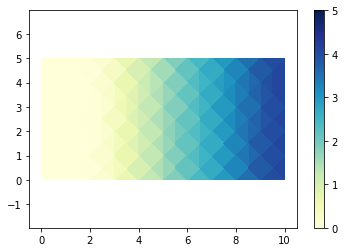

In [6]:
import matplotlib.tri as mtri
import matplotlib.pyplot as plt
# IPython magic command to create figures within the notebook
%matplotlib inline

triang = mtri.Triangulation(x, y)

plt.figure()
plt.tripcolor(triang, depth[-1],  edgecolors='None', cmap='YlGnBu', vmin = 0, vmax = 5)
plt.colorbar()
plt.axis('equal');

### Animate (slow!)

Use this script to create and play an animation of the model run.

In [14]:
from matplotlib import animation
from mpl_toolkits.mplot3d import Axes3D
from anuga_tools.animate import *

fig = plt.figure()
ax = fig.gca(projection='3d')

def animate(i):
    ax.clear()
    ax.plot_trisurf(triang, elev, color='navajowhite', edgecolors='none', antialiased=False, shade=False)
    ax.plot_trisurf(triang, stage[i*step], color='dodgerblue', alpha=0.5, linewidth=0, antialiased=False, shade=False)
    ax.set_zlim(elev.min(), np.max([stage.max(), elev.max()]))

# increase step to skip frames; increase interval to increase movie speed
step = 1
anim = animation.FuncAnimation(fig, animate, frames=len(depth)/step, interval=20)
display_animation(anim)